# Spot

**Goal**: Train a neural network to identify a dog's breed from its photo

To upload your own photos and get a breed prediction, check out the web version here: https://breed-spot.herokuapp.com/

In [3]:
from bs4 import *
import requests
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import pickle
import time
import sys

# Step 1: Scrape embark.com for dog photos and DNA results

The dog breed and image data was obtained from Embark.com, a dog DNA testing service. Each dog has a public profile with their DNA test results, and the owners can upload photos to their gallery to connect with their doggie relatives. I used a list of over 1000 popular dog names to generate profile ids (e.g. Rover1, Rover2, ...) and downloaded the breed mix and photos for each dog that had photos in their gallery. 

In [4]:
#function to download images from a dog's profile and save to folder
def download_gallery(name):
    folder_name = 'dogs/%s'%name
    if os.path.exists(folder_name):
        print('%s folder already exists'%folder_name)
        return 0
    
    url = 'https://my.embarkvet.com/dog/%s/gallery'%name
    
    r = requests.get(url)
    if r.status_code == 404 or 'Code not recognized' in r.text:
        print('%s does not exist'%name)
        return -1
    soup = BeautifulSoup(r.text, 'html.parser')
    images = soup.findAll('img')[1:] #find all images on page, skip first which is embark logo
    if len(images) == 0:
        print('%s has no photos'%name)
        return 0
    os.mkdir(folder_name)
    count = 0
    for i, image in enumerate(images):
        try:
            image_link = image["data-srcset"]
        except:
            try:
                image_link = image["data-src"]
            except:
                try:
                    image_link = image["data-fallback-src"]
                except:
                    try:
                        image_link = image["src"]
                    except:
                        pass

        try:
            r = requests.get(image_link).content
            try:
                r = str(r, 'utf-8')
            except UnicodeDecodeError:
                with open(f"{folder_name}/images{i+1}.jpg", "wb+") as f:
                    f.write(r)
                count += 1 #successful download 
        except:
            pass

    #if all images downloaded
    if count == len(images):
        print("All Images Downloaded for %s"%name)
    # if not all images downloaded
    else:
        print(f"Total {count} Images Downloaded Out of {len(images)} for %s"%name)
        
    return count

In [8]:
#read in file listing popular dog names, remove duplicates
names = np.unique(np.genfromtxt('popular_dog_names',dtype=str))

In [11]:
#for each name, generate profile names (dog name + integer) and download that dog's photos if they exist
for name in names:
    name = name.lower()
    i = 0
    not_found = 0
    while not_found < 20: #quit searching after 20 profiles not found in a row
        n = download_gallery("%s%d"%(name,i) if i > 0 else name)
        if n == -1:
            not_found += 1
        i += 1

In [12]:
# for all the dogs we have images of, find their profile and download their breed info 
dogs = os.popen('ls dogs').read().split() #list of dog profiles
breed_names = {}
count = 0
for dog in dogs:
    count += 1
    url = 'https://my.embarkvet.com/dog/%s'%dog
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'html.parser')
    scripts = soup.find_all('script')
    script = None
    for s in scripts:
        if len(s.contents) > 0 and 'breedName' in s.contents[0]:
            script = s
    if script:
        cont = script.contents
        data = cont[0].split('\n')
        f = open('dogs/%s/breed'%dog,'w')
        for d in data:
            if 'ancestryLabel' in d:
                breed = d.split(':')[1][2:-2]
            if 'breedName' in d:
                breed_names[breed] = d.split(':')[1][2:-2]
            if 'breedPct' in d:
                f.write('%s %s\n'%(breed,d.split(':')[1][1:-1]))
        f.close()
        print('breed file written for %s'%dog)
    else:
        print('breeds not found for %s'%dog)
        f = open('dogs/%s/no_breed'%dog,'w')
        f.close()
        print('requests %d'%count)
    time.sleep(7) #to avoid request limit 

Read breed files into a pandas dataframe:

In [17]:
breeds = {}
for dog in dogs:
    if os.path.exists('dogs/%s/breed'%dog) and len(os.popen('ls dogs/%s/*.jpg'%dog).read().split()) > 0:
        breeds[dog] = {}
        with open('dogs/%s/breed'%dog) as f:
            for line in f:
                (key, val) = line.split()
                breeds[dog][key] = float(val)

In [20]:
breed_df = pd.DataFrame.from_dict(breeds,orient='index').fillna(0)
dog_names = breed_df.index
# breed_df.to_pickle('breed_df')  #save dataframe to file 

In [21]:
# breed_df = pd.read_pickle('breed_df') #read dataframe from file

In [26]:
breed_df

,poodle_small,shih_tzu,dachshund_merged,keeshond,doberman_pinscher,german_shepherd_dog,cocker_spaniel,mix,australian_shepherd,cane_corso,...,west_african_village_dog,indian_indigenous_dog,slovensky_cuvac,laika,sapsali,polynesian_village_dog,village_dog_southeast_asian_island,shikoku,deutscher_wachtelhund,romanian_mioritic_shepherd_dog
abbott,31.9,12.5,12.0,10.1,9.3,6.4,6.1,11.7,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abbott14,8.0,0.0,0.0,0.0,0.0,0.0,0.0,5.3,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abbott20,6.6,13.4,15.6,0.0,0.0,0.0,4.7,13.8,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abby1013,11.5,0.0,11.3,0.0,0.0,0.0,0.0,12.4,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abby1036,21.1,0.0,0.0,0.0,0.0,5.2,10.3,20.3,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
moose494,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mae35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
maple681,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
monty66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Step 2: Clean up data

The dataset includes 348 different dog breeds. Many of these are rare dog breeds that are only seen a few times in this sample of dogs. After removing these and any dogs that are majority rare breeds, the dataset includes 302,168 from 85 different breeds.

In [27]:
freq = (breed_df > 0).sum() #frequency of each breed
freq.sort_values()

romanian_mioritic_shepherd_dog         1
xigou                                  1
lapponian_herder                       1
south_russian_shepherd_dog             1
norrbottenspitz                        1
                                   ...  
chow_chow                          59645
labrador_retriever                 77058
german_shepherd_dog               111463
american_pit_bull_terrier         123594
mix                               155740
Length: 348, dtype: int64

In [28]:
#keep only breeds that appear in more than 1000 dogs
bof = freq[freq >= 1000].index #breeds of interest
breed_df = breed_df[bof]

#remove dogs who are > 25% rare breeds
breed_df = breed_df.loc[breed_df.sum(axis=1) > 75]

In [29]:
#for dogs that had < 25% rare breeds, just rescale the remaining breeds to add to 100%
breed_df = breed_df.divide(breed_df.sum(axis=1),axis='rows') #all rows add to 1
breed_df = breed_df.sort_index().sort_index(axis=1) #sort alphabetically 

In [30]:
breed_df

,akita,alaskan_malamute,american_bully,american_english_coonhound,american_eskimo_dog,american_foxhound,american_pit_bull_terrier,american_staffordshire_terrier,american_village_dog,australian_cattle_dog,...,samoyed,shetland_sheepdog,shih_tzu,siberian_husky,silky_terrier,staffordshire_terrier,toy_fox_terrier,treeing_walker_coonhound,weimaraner,yorkshire_terrier
abbott,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.000,...,0.0,0.0,0.139043,0.0,0.0,0.0,0.0,0.0,0.000,0.0
abbott10,0.0,0.0,0.0,0.0,0.0,0.0,0.126,0.063,0.0,0.144,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000,0.0
abbott12,0.0,0.0,0.0,0.0,0.0,0.0,0.416,0.101,0.0,0.000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000,0.0
abbott14,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.063,0.0,0.223,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000,0.0
abbott15,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
rocky992,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000,0.0
rocky993,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.136,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.048,0.0
rocky994,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.781,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000,0.0
rocky997,0.0,0.0,0.0,0.0,0.0,0.0,0.290,0.052,0.0,0.000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000,0.0


# Step 3: Split data in training and validation sets

It turns out that training a model to predict a breed composition is mathematically challenging (see Bonus section at the end if you're curious why!), so the model is trained on purebred dogs only (about 50,000 dogs).

Because many dogs have several images, instead of splitting the *images* into training and validation sets, the *dogs* are split into training and validation sets. This avoids overfitting on very similar photos of the same dog.

In [35]:
purebred_df = breed_df.loc[breed_df.max(axis=1) == 1] #dogs who are 100% one breed
purebred_df

,akita,alaskan_malamute,american_bully,american_english_coonhound,american_eskimo_dog,american_foxhound,american_pit_bull_terrier,american_staffordshire_terrier,american_village_dog,australian_cattle_dog,...,samoyed,shetland_sheepdog,shih_tzu,siberian_husky,silky_terrier,staffordshire_terrier,toy_fox_terrier,treeing_walker_coonhound,weimaraner,yorkshire_terrier
abbott15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abby,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abby1002,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abby1019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
abby102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
rocky944,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
rocky955,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
rocky963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
rocky990,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
# assign 80% of dogs to training data and remaining 20% to validation
dogs = np.array(purebred_df.index)
np.random.shuffle(dogs)
train_dogs = dogs[:int(len(dogs)*0.8)]
valid_dogs = dogs[int(len(dogs)*0.8):]

In [42]:
# move train and validation into own folders
for dog in train_dogs:
    os.system('mv dogs/%s dogs/train_purebred/%s'%(dog,dog))
for dog in valid_dogs:
    os.system('mv dogs/%s dogs/valid_purebred/%s'%(dog,dog))

# Step 4: Build the neural network 

The starting point of the model is the convolutional neural network Xception, which was developed by Google to classify images into over 1000 different classes. Even though none of these classes are dog breeds, using the pre-trained CNN weights helps the model to pick up features like edges and gradients. The final fully-connected layers that classify images into 1000 different classes are replaced with new layers that classify images into 85 different dog breeds. Two dropout layers are included to prevent overfitting.

In [46]:
xception = tf.keras.applications.xception.Xception(include_top = False, pooling = 'max')
xception.trainable=False

In [39]:
model = tf.keras.models.Sequential()
model.add(xception)
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1024,activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(purebred_df.shape[1]))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 85)                87125     
                                                                 
Total params: 23,046,781
Trainable params: 2,185,301
Non-trainable params: 20,861,480
_________________________________________________________________


# Step 5: Train the neural network

The dataset is too large to hold in memory all at once (50+ GB of jpgs), so the TensorFlow function image_dataset_from_directory is used to create a dataset that is read from disk during training. The model is trained for 10 epochs using the cross entropy loss function.

In [42]:
# gets dogs into the same order they are read by image_dataset_from_directory
# counts number of images per directory to assign labels correctly
train_pb_num_imgs = []
train_pb_dog_names = []
for directory in os.walk('dogs/train_purebred'): #count number of images in each directory (needed by image_dataset_from_directory)
    train_pb_num_imgs.append(len(directory[2])-1)
    train_pb_dog_names.append(directory[0][20:])
train_pb_num_imgs = train_pb_num_imgs[1:]
train_pb_dog_names = train_pb_dog_names[1:]

train_pb_num_imgs = np.array(train_pb_num_imgs)[np.argsort(train_pb_dog_names)]
train_pb_dog_names = np.sort(train_pb_dog_names)

valid_pb_num_imgs = []
valid_pb_dog_names = []
for directory in os.walk('dogs/valid_purebred'): 
    valid_pb_num_imgs.append(len(directory[2])-1)
    valid_pb_dog_names.append(directory[0][20:])
valid_pb_num_imgs = valid_pb_num_imgs[1:]
valid_pb_dog_names = valid_pb_dog_names[1:]

valid_pb_num_imgs = np.array(valid_pb_num_imgs)[np.argsort(valid_pb_dog_names)]
valid_pb_dog_names = np.sort(valid_pb_dog_names)

# each dog breed is converted to an integer (sparse categorical data)
col_idx = np.broadcast_to(np.arange(0,len(purebred_df.columns)),(len(train_pb_dog_names),len(purebred_df.columns)))
train_pb_labels = col_idx[purebred_df.loc[train_pb_dog_names] > 0]
train_pb_labels = np.repeat(train_pb_labels,train_pb_num_imgs).tolist() 

col_idx = np.broadcast_to(np.arange(0,len(purebred_df.columns)),(len(valid_pb_dog_names),len(purebred_df.columns)))
valid_pb_labels = col_idx[purebred_df.loc[valid_pb_dog_names] > 0]
valid_pb_labels = np.repeat(valid_pb_labels,valid_pb_num_imgs).tolist() 

In [43]:
# read training data 
train_pb_images = tf.keras.utils.image_dataset_from_directory('dogs/train_purebred',
    labels=train_pb_labels,label_mode='int',image_size=(299, 299),
    crop_to_aspect_ratio=True,seed=46)

Found 89203 files belonging to 40340 classes.


In [44]:
# read validation data
valid_pb_images = tf.keras.utils.image_dataset_from_directory('dogs/valid_purebred',
    labels=valid_pb_labels,label_mode='int',image_size=(299, 299),
    crop_to_aspect_ratio=True,seed=46)

Found 22127 files belonging to 10127 classes.


In [45]:
# preprocesses image data into the format expected by Xception
train_pb_images_xception = train_pb_images.map(lambda x, y : (tf.keras.applications.xception.preprocess_input(x), y))
valid_pb_images_xception = valid_pb_images.map(lambda x, y : (tf.keras.applications.xception.preprocess_input(x), y))

In [47]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics='sparse_categorical_accuracy')
history = model.fit(train_pb_images_xception,validation_data=valid_pb_images_xception,batch_size=32,epochs=10)

Epoch 1/10


2022-11-10 12:43:29.049928: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


 358/2788 [==>...........................] - ETA: 15:22 - loss: 1.8760 - sparse_categorical_accuracy: 0.5519

2022-11-10 12:45:49.873518: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


 516/2788 [====>.........................] - ETA: 14:22 - loss: 1.7007 - sparse_categorical_accuracy: 0.5809

2022-11-10 12:46:49.880727: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1430/2788 [==============>...............] - ETA: 8:35 - loss: 1.3715 - sparse_categorical_accuracy: 0.6306

2022-11-10 12:52:36.305568: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1751/2788 [=================>............] - ETA: 6:33 - loss: 1.3279 - sparse_categorical_accuracy: 0.6381

2022-11-10 12:54:38.080313: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1941/2788 [===================>..........] - ETA: 5:21 - loss: 1.3043 - sparse_categorical_accuracy: 0.6416

2022-11-10 12:55:50.079433: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2303/2788 [=======================>......] - ETA: 3:03 - loss: 1.2703 - sparse_categorical_accuracy: 0.6479

2022-11-10 12:58:07.600818: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


2326/2788 [========================>.....] - ETA: 2:55 - loss: 1.2697 - sparse_categorical_accuracy: 0.6482

2022-11-10 12:58:16.381272: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


2386/2788 [========================>.....] - ETA: 2:32 - loss: 1.2657 - sparse_categorical_accuracy: 0.6490

2022-11-10 12:58:39.197579: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


2601/2788 [==========================>...] - ETA: 1:10 - loss: 1.2542 - sparse_categorical_accuracy: 0.6513

2022-11-10 13:00:00.565440: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


2788/2788 [==============================] - 1321s 472ms/step - loss: 1.2451 - sparse_categorical_accuracy: 0.6531 - val_loss: 0.8844 - val_sparse_categorical_accuracy: 0.7350
Epoch 2/10
 358/2788 [==>...........................] - ETA: 15:18 - loss: 1.0907 - sparse_categorical_accuracy: 0.6769

2022-11-10 13:07:45.631761: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


 516/2788 [====>.........................] - ETA: 14:19 - loss: 1.0768 - sparse_categorical_accuracy: 0.6836

2022-11-10 13:08:45.433178: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1430/2788 [==============>...............] - ETA: 8:33 - loss: 1.0637 - sparse_categorical_accuracy: 0.6852

2022-11-10 13:14:31.150615: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1751/2788 [=================>............] - ETA: 6:32 - loss: 1.0616 - sparse_categorical_accuracy: 0.6859

2022-11-10 13:16:32.569027: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1941/2788 [===================>..........] - ETA: 5:20 - loss: 1.0584 - sparse_categorical_accuracy: 0.6871

2022-11-10 13:17:44.467637: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2303/2788 [=======================>......] - ETA: 3:03 - loss: 1.0567 - sparse_categorical_accuracy: 0.6878

2022-11-10 13:20:01.826896: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


2326/2788 [========================>.....] - ETA: 2:54 - loss: 1.0561 - sparse_categorical_accuracy: 0.6879

2022-11-10 13:20:10.533740: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


2386/2788 [========================>.....] - ETA: 2:32 - loss: 1.0567 - sparse_categorical_accuracy: 0.6876

2022-11-10 13:20:33.254357: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


2601/2788 [==========================>...] - ETA: 1:10 - loss: 1.0583 - sparse_categorical_accuracy: 0.6872

2022-11-10 13:21:54.786270: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


2788/2788 [==============================] - 1315s 472ms/step - loss: 1.0581 - sparse_categorical_accuracy: 0.6875 - val_loss: 0.8598 - val_sparse_categorical_accuracy: 0.7404
Epoch 3/10
 358/2788 [==>...........................] - ETA: 15:20 - loss: 1.0518 - sparse_categorical_accuracy: 0.6935

2022-11-10 13:29:41.191721: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


 516/2788 [====>.........................] - ETA: 14:20 - loss: 1.0428 - sparse_categorical_accuracy: 0.6983

2022-11-10 13:30:40.956962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1430/2788 [==============>...............] - ETA: 8:34 - loss: 1.0298 - sparse_categorical_accuracy: 0.6991

2022-11-10 13:36:27.546977: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1751/2788 [=================>............] - ETA: 6:33 - loss: 1.0286 - sparse_categorical_accuracy: 0.6994

2022-11-10 13:38:29.614777: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1941/2788 [===================>..........] - ETA: 5:21 - loss: 1.0271 - sparse_categorical_accuracy: 0.6999

2022-11-10 13:39:42.324492: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2303/2788 [=======================>......] - ETA: 3:04 - loss: 1.0252 - sparse_categorical_accuracy: 0.7003

2022-11-10 13:42:00.940242: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


2326/2788 [========================>.....] - ETA: 2:55 - loss: 1.0246 - sparse_categorical_accuracy: 0.7002

2022-11-10 13:42:09.747125: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


2386/2788 [========================>.....] - ETA: 2:32 - loss: 1.0255 - sparse_categorical_accuracy: 0.6999

2022-11-10 13:42:32.688332: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


2601/2788 [==========================>...] - ETA: 1:11 - loss: 1.0266 - sparse_categorical_accuracy: 0.7001

2022-11-10 13:43:55.133922: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


2788/2788 [==============================] - 1325s 475ms/step - loss: 1.0274 - sparse_categorical_accuracy: 0.6994 - val_loss: 0.8568 - val_sparse_categorical_accuracy: 0.7436
Epoch 4/10
 358/2788 [==>...........................] - ETA: 15:35 - loss: 1.0259 - sparse_categorical_accuracy: 0.6966

2022-11-10 13:51:47.951708: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


 516/2788 [====>.........................] - ETA: 14:34 - loss: 1.0108 - sparse_categorical_accuracy: 0.7017

2022-11-10 13:52:48.761601: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1430/2788 [==============>...............] - ETA: 8:42 - loss: 1.0037 - sparse_categorical_accuracy: 0.7047

2022-11-10 13:58:40.170513: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1751/2788 [=================>............] - ETA: 6:38 - loss: 1.0032 - sparse_categorical_accuracy: 0.7043

2022-11-10 14:00:43.484995: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1941/2788 [===================>..........] - ETA: 5:25 - loss: 1.0015 - sparse_categorical_accuracy: 0.7050

2022-11-10 14:01:56.537870: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2304/2788 [=======================>......] - ETA: 3:06 - loss: 1.0027 - sparse_categorical_accuracy: 0.7052

2022-11-10 14:04:16.187533: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


2327/2788 [========================>.....] - ETA: 2:57 - loss: 1.0034 - sparse_categorical_accuracy: 0.7049

2022-11-10 14:04:25.048141: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


2387/2788 [========================>.....] - ETA: 2:34 - loss: 1.0050 - sparse_categorical_accuracy: 0.7046

2022-11-10 14:04:48.091808: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


2602/2788 [==========================>...] - ETA: 1:11 - loss: 1.0054 - sparse_categorical_accuracy: 0.7048

2022-11-10 14:06:10.685051: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


2788/2788 [==============================] - 1336s 479ms/step - loss: 1.0065 - sparse_categorical_accuracy: 0.7045 - val_loss: 0.8489 - val_sparse_categorical_accuracy: 0.7457
Epoch 5/10
 358/2788 [==>...........................] - ETA: 15:36 - loss: 1.0177 - sparse_categorical_accuracy: 0.6992

2022-11-10 14:14:03.627706: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


 516/2788 [====>.........................] - ETA: 14:34 - loss: 1.0062 - sparse_categorical_accuracy: 0.7043

2022-11-10 14:15:04.392766: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1430/2788 [==============>...............] - ETA: 8:42 - loss: 0.9967 - sparse_categorical_accuracy: 0.7069

2022-11-10 14:20:55.778819: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1751/2788 [=================>............] - ETA: 6:38 - loss: 0.9894 - sparse_categorical_accuracy: 0.7084

2022-11-10 14:22:59.112225: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1941/2788 [===================>..........] - ETA: 5:25 - loss: 0.9892 - sparse_categorical_accuracy: 0.7088

2022-11-10 14:24:12.230531: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2303/2788 [=======================>......] - ETA: 3:06 - loss: 0.9899 - sparse_categorical_accuracy: 0.7093

2022-11-10 14:26:31.231907: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


2326/2788 [========================>.....] - ETA: 2:57 - loss: 0.9893 - sparse_categorical_accuracy: 0.7094

2022-11-10 14:26:40.089898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


2386/2788 [========================>.....] - ETA: 2:34 - loss: 0.9909 - sparse_categorical_accuracy: 0.7086

2022-11-10 14:27:03.142491: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


2601/2788 [==========================>...] - ETA: 1:11 - loss: 0.9927 - sparse_categorical_accuracy: 0.7082

2022-11-10 14:28:25.760307: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


2788/2788 [==============================] - 1335s 479ms/step - loss: 0.9925 - sparse_categorical_accuracy: 0.7080 - val_loss: 0.8573 - val_sparse_categorical_accuracy: 0.7463
Epoch 6/10
 358/2788 [==>...........................] - ETA: 15:35 - loss: 1.0039 - sparse_categorical_accuracy: 0.7041

2022-11-10 14:36:18.793549: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


 516/2788 [====>.........................] - ETA: 14:34 - loss: 0.9911 - sparse_categorical_accuracy: 0.7095

2022-11-10 14:37:19.546681: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1430/2788 [==============>...............] - ETA: 8:42 - loss: 0.9839 - sparse_categorical_accuracy: 0.7119

2022-11-10 14:43:10.749408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1751/2788 [=================>............] - ETA: 6:38 - loss: 0.9837 - sparse_categorical_accuracy: 0.7123

2022-11-10 14:45:13.509122: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1941/2788 [===================>..........] - ETA: 5:24 - loss: 0.9825 - sparse_categorical_accuracy: 0.7129

2022-11-10 14:46:25.662189: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2303/2788 [=======================>......] - ETA: 3:05 - loss: 0.9839 - sparse_categorical_accuracy: 0.7118

2022-11-10 14:48:42.581459: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


2326/2788 [========================>.....] - ETA: 2:56 - loss: 0.9835 - sparse_categorical_accuracy: 0.7120

2022-11-10 14:48:51.286080: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


2386/2788 [========================>.....] - ETA: 2:33 - loss: 0.9841 - sparse_categorical_accuracy: 0.7115

2022-11-10 14:49:13.957055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


2601/2788 [==========================>...] - ETA: 1:11 - loss: 0.9862 - sparse_categorical_accuracy: 0.7109

2022-11-10 14:50:35.290654: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


2788/2788 [==============================] - 1324s 475ms/step - loss: 0.9869 - sparse_categorical_accuracy: 0.7104 - val_loss: 0.8390 - val_sparse_categorical_accuracy: 0.7480
Epoch 7/10
 358/2788 [==>...........................] - ETA: 15:23 - loss: 0.9874 - sparse_categorical_accuracy: 0.7046

2022-11-10 14:58:21.135782: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


 516/2788 [====>.........................] - ETA: 14:21 - loss: 0.9895 - sparse_categorical_accuracy: 0.7116

2022-11-10 14:59:20.821807: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1430/2788 [==============>...............] - ETA: 8:33 - loss: 0.9770 - sparse_categorical_accuracy: 0.7136

2022-11-10 15:05:05.927558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1751/2788 [=================>............] - ETA: 6:32 - loss: 0.9771 - sparse_categorical_accuracy: 0.7143

2022-11-10 15:07:07.260027: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1941/2788 [===================>..........] - ETA: 5:20 - loss: 0.9790 - sparse_categorical_accuracy: 0.7144

2022-11-10 15:08:19.123408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2304/2788 [=======================>......] - ETA: 3:03 - loss: 0.9813 - sparse_categorical_accuracy: 0.7140

2022-11-10 15:10:36.448325: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


2327/2788 [========================>.....] - ETA: 2:54 - loss: 0.9816 - sparse_categorical_accuracy: 0.7138

2022-11-10 15:10:45.158117: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


2387/2788 [========================>.....] - ETA: 2:31 - loss: 0.9824 - sparse_categorical_accuracy: 0.7134

2022-11-10 15:11:07.792208: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


2602/2788 [==========================>...] - ETA: 1:10 - loss: 0.9849 - sparse_categorical_accuracy: 0.7128

2022-11-10 15:12:28.979737: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


2788/2788 [==============================] - 1314s 471ms/step - loss: 0.9836 - sparse_categorical_accuracy: 0.7128 - val_loss: 0.8377 - val_sparse_categorical_accuracy: 0.7493
Epoch 8/10
 358/2788 [==>...........................] - ETA: 15:23 - loss: 0.9753 - sparse_categorical_accuracy: 0.7095

2022-11-10 15:20:15.088804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


 516/2788 [====>.........................] - ETA: 14:23 - loss: 0.9653 - sparse_categorical_accuracy: 0.7137

2022-11-10 15:21:15.238127: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1430/2788 [==============>...............] - ETA: 8:35 - loss: 0.9645 - sparse_categorical_accuracy: 0.7136

2022-11-10 15:27:01.612287: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1751/2788 [=================>............] - ETA: 6:33 - loss: 0.9642 - sparse_categorical_accuracy: 0.7143

2022-11-10 15:29:03.618250: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1941/2788 [===================>..........] - ETA: 5:21 - loss: 0.9637 - sparse_categorical_accuracy: 0.7143

2022-11-10 15:30:15.973331: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2303/2788 [=======================>......] - ETA: 3:04 - loss: 0.9649 - sparse_categorical_accuracy: 0.7146

2022-11-10 15:32:33.275956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


2326/2788 [========================>.....] - ETA: 2:55 - loss: 0.9652 - sparse_categorical_accuracy: 0.7146

2022-11-10 15:32:42.044556: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


2386/2788 [========================>.....] - ETA: 2:32 - loss: 0.9659 - sparse_categorical_accuracy: 0.7146

2022-11-10 15:33:04.798728: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


2601/2788 [==========================>...] - ETA: 1:10 - loss: 0.9684 - sparse_categorical_accuracy: 0.7149

2022-11-10 15:34:26.362230: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


2788/2788 [==============================] - 1319s 473ms/step - loss: 0.9711 - sparse_categorical_accuracy: 0.7146 - val_loss: 0.8458 - val_sparse_categorical_accuracy: 0.7492
Epoch 9/10
 358/2788 [==>...........................] - ETA: 15:26 - loss: 1.0082 - sparse_categorical_accuracy: 0.7083

2022-11-10 15:42:14.424636: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


 516/2788 [====>.........................] - ETA: 14:24 - loss: 0.9869 - sparse_categorical_accuracy: 0.7137

2022-11-10 15:43:14.202537: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1430/2788 [==============>...............] - ETA: 8:34 - loss: 0.9689 - sparse_categorical_accuracy: 0.7169

2022-11-10 15:48:59.795052: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1751/2788 [=================>............] - ETA: 6:32 - loss: 0.9684 - sparse_categorical_accuracy: 0.7166

2022-11-10 15:51:01.220425: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1941/2788 [===================>..........] - ETA: 5:20 - loss: 0.9675 - sparse_categorical_accuracy: 0.7169

2022-11-10 15:52:13.079714: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2303/2788 [=======================>......] - ETA: 3:03 - loss: 0.9692 - sparse_categorical_accuracy: 0.7168

2022-11-10 15:54:30.176141: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


2326/2788 [========================>.....] - ETA: 2:54 - loss: 0.9693 - sparse_categorical_accuracy: 0.7168

2022-11-10 15:54:38.967159: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


2386/2788 [========================>.....] - ETA: 2:32 - loss: 0.9701 - sparse_categorical_accuracy: 0.7163

2022-11-10 15:55:01.662909: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


2601/2788 [==========================>...] - ETA: 1:10 - loss: 0.9711 - sparse_categorical_accuracy: 0.7164

2022-11-10 15:56:22.869314: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


2788/2788 [==============================] - 1314s 471ms/step - loss: 0.9719 - sparse_categorical_accuracy: 0.7159 - val_loss: 0.8698 - val_sparse_categorical_accuracy: 0.7418
Epoch 10/10
 358/2788 [==>...........................] - ETA: 15:19 - loss: 0.9703 - sparse_categorical_accuracy: 0.7159

2022-11-10 16:04:07.462627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


 516/2788 [====>.........................] - ETA: 14:20 - loss: 0.9693 - sparse_categorical_accuracy: 0.7195

2022-11-10 16:05:07.400253: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1430/2788 [==============>...............] - ETA: 8:34 - loss: 0.9659 - sparse_categorical_accuracy: 0.7180

2022-11-10 16:10:53.632632: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1751/2788 [=================>............] - ETA: 6:32 - loss: 0.9660 - sparse_categorical_accuracy: 0.7176

2022-11-10 16:12:55.522597: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


1941/2788 [===================>..........] - ETA: 5:21 - loss: 0.9649 - sparse_categorical_accuracy: 0.7181

2022-11-10 16:14:07.704647: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2303/2788 [=======================>......] - ETA: 3:03 - loss: 0.9635 - sparse_categorical_accuracy: 0.7182

2022-11-10 16:16:25.044755: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


2326/2788 [========================>.....] - ETA: 2:55 - loss: 0.9636 - sparse_categorical_accuracy: 0.7181

2022-11-10 16:16:33.773617: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


2386/2788 [========================>.....] - ETA: 2:32 - loss: 0.9638 - sparse_categorical_accuracy: 0.7178

2022-11-10 16:16:56.623486: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


2601/2788 [==========================>...] - ETA: 1:10 - loss: 0.9643 - sparse_categorical_accuracy: 0.7180

2022-11-10 16:18:18.598109: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


2788/2788 [==============================] - 1317s 472ms/step - loss: 0.9655 - sparse_categorical_accuracy: 0.7177 - val_loss: 0.8489 - val_sparse_categorical_accuracy: 0.7491


In [48]:
# model.save('model.h5') #saves model and weights to disk

(-0.5, 9.5)

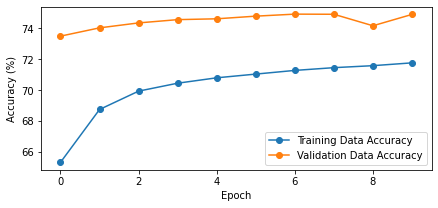

In [94]:
plt.figure(figsize=(7,3))
plt.plot(np.array(history.history['sparse_categorical_accuracy'])*100,'o-',label='Training Data Accuracy')
plt.plot(np.array(history.history['val_sparse_categorical_accuracy'])*100,'o-',label='Validation Data Accuracy')
plt.legend()
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.xlim([-0.5,9.5])
# plt.ylim([0,100])

The validation data has higher accuracy than the training data since the dropout layers are removed during validation predictions. Both accuracies are increasing (slowly) during training, so the model is not overfitting to the training data.


# Step 6: Check out some of the model's predictions!

Statistically, the model has 75\% accuracy on the validation dataset, but it's more fun to look at some examples of the model output. Below are 10 dogs from the validation dataset and their associated breed predictions. 

The left column shows the dog's photo and its actual breed. The right pie chart shows the model output and relative probabilities of each of the possible breeds. Considering the quality of some of the photos, I think the accuracy is on par with or better than an informed human. The breeds most frequently mixed up are the American Pit Bull Terrier and American Bully, which have very similar faces but slightly different builds (Bullys are more muscular). 

If you want to try out the model with your own dog, you can upload a photo [here](https://breed-spot.herokuapp.com/).

1/1 [==============================] - 0s 53ms/step


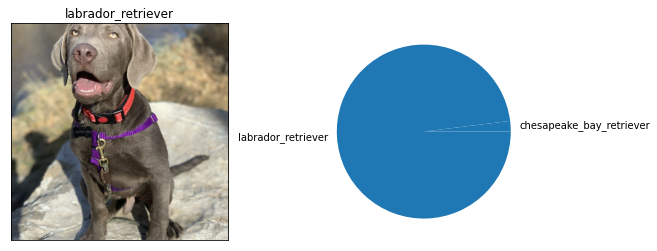

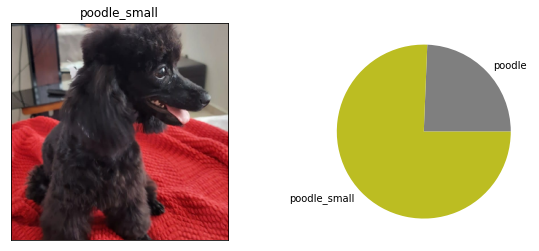

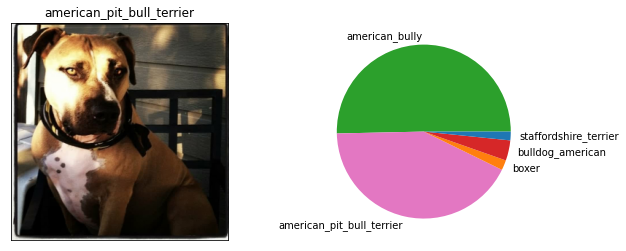

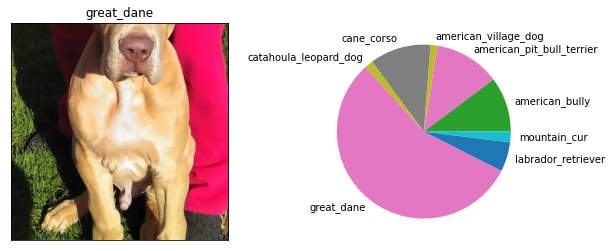

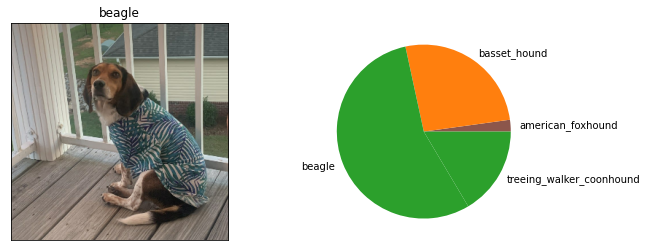

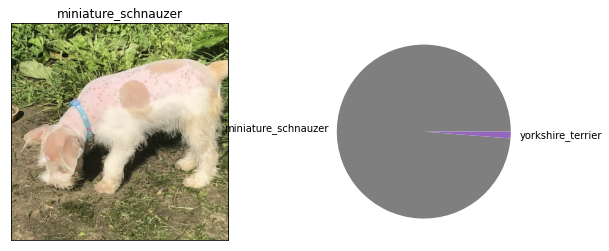

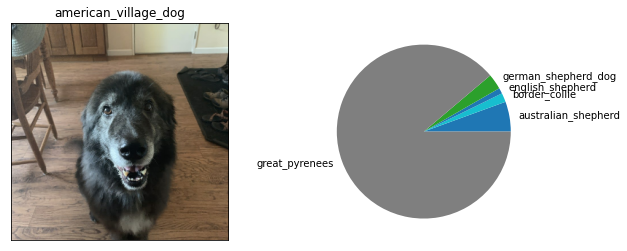

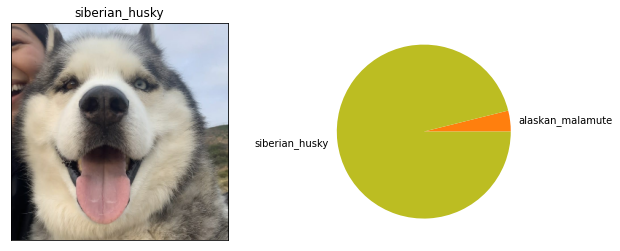

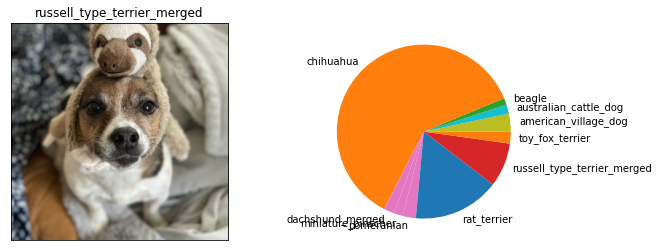

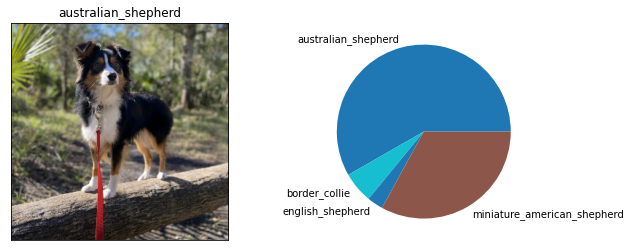

In [78]:
for dog in valid_pb_images_xception.take(1):
    predictions = model.predict(dog[0])
    for i in range(10):
        fig,axes = plt.subplots(ncols=2,figsize=(10,4))
        axes[0].imshow((dog[0][i]+1)/2)
        axes[0].set_title(purebred_df.columns[int(dog[1][i])])
        temp = pd.DataFrame(columns=purebred_df.columns)
        temp.loc[0] = tf.nn.softmax(predictions[i])
        temp.loc[0].where(temp.loc[0]>0.01,0).plot.pie(ax=axes[1]) #set probabilites < 0.01 to 0
        axes[0].set_xticks([])
        axes[0].set_yticks([])
        axes[1].set_ylabel('')

# Bonus: Why is it so difficult to predict breed compositions for mixed breed dogs?

My original goal with this project was to predict the mix of breeds (e.g., 50\% poodle, 50\% chihuahua) for an individual dog from a photo. This kind of data is called compositional data and appears in a variety of fields, from geology to economics. The vector space of valid compositional data forms what is known as a simplex, where all components sum to 100%. Performing regressions within the simplex is not a straight-forward task and care needs to be taken to avoid spurious correlations between the different components. 

One method that has been applied mostly in the geology space is the use of log-ratios [1], which involves taking the log of the ratios between different components. This can't be used, however, if there are zeros present in the data, since the log(0) and x/0 are both undefined. The dog breed data is mostly zeros, so this won't work.

Recently, a new probability distribution known as the *continuous categorical distribution* was developed, which can handle zeros [2]. The loss function for this distribution resembles a generalization of the categorical cross entropy, plus a normalization constant. Unfortunately, the normalization constant is numerically unstable when the number of categories is high [3], and with 85 different breed categories, it's impossible to calculate even a single significant digit with double precision.

I'm looking forward to following the research in this space so that eventually our mixed breed friends can be included in the model!

[1] [Aitchison, J. (1982). The statistical analysis of compositional data. Journal of the Royal Statistical Society: Series B (Methodological), 44(2), 139-160.](https://doi.org/10.1111/j.2517-6161.1982.tb01195.x)

[2] [Gordon-Rodriguez, E., Loaiza-Ganem, G., & Cunningham, J. (2020, November). The continuous categorical: a novel simplex-valued exponential family. In International Conference on Machine Learning (pp. 3637-3647). PMLR.](https://proceedings.mlr.press/v119/gordon-rodriguez20a.html)

[3] [Gordon-Rodriguez, E., Loaiza-Ganem, G., Potapczynski, A., & Cunningham, J. P. (2022). On the normalizing constant of the continuous categorical distribution. arXiv preprint arXiv:2204.13290](https://arxiv.org/pdf/2204.13290.pdf)